# B. Time-series extraction from the downloaded NetCDF files (seasonal forecasts datasets)

In this Notebook we will extract the time-series data from the downloaded NetCDF files and convert them to CSV format to more easily read the data in Python. In addition, you will calculate the areal mean values when the region of study is contained by several grid cells.

The downloaded forecast files are in [NetCDF](https://confluence.ecmwf.int/display/CKB/What+are+NetCDF+files+and+how+can+I+read+them) (Network Common Data Form) format. This file format supports the creation, access, and sharing of array-oriented scientific data.
Here we will extract temperature, evaporation and rainfall data using their corresponding short names: 't2m' (temperature), 'e' (evaporation) and 'tp' (rainfall) respectively and save the forecast ensemble for each of these weather variables in CSV (the files are stored in the Inputs folder).  

**Comment:** You can find a complete list of weather variables with their corresponding short names in this [link](https://apps.ecmwf.int/codes/grib/param-db/?filter=netcdf).

**Comment:** A CSV is a comma-separated values file, which allows data to be saved in a tabular format. CSV files can be used either with most any spreadsheet program, such as Microsoft Excel, or text editors.

## 1. Import libraries
Let's start by importing the necessary libraries (🚨 in order to run the code like in the cell below, place the mouse pointer in the cell, then click on “run cell” button above or press shift + enter).

In [8]:
import cdsapi
import netCDF4
from netCDF4 import num2date, Dataset
import numpy as np
import os
import pandas as pd
import datetime
import matplotlib
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import matplotlib.dates as mdates
from IPython.display import Image

## 2. Basic settings
Before extract time series, you have to clear what and when to extract as follows;

In [9]:
# Overall info.
catch_name = 'cj'              # Name of catchment that you want to extract time-series
variable = 'tp'                # Kind of variables that you want to extract time-series such as tp, e, t2m

# We define the parameters for the extraction
originating_centre = 'ECMWF'

start_year = 2020 # Download start year
end_year   = 2020 # Download end year
years      = range(start_year, end_year + 1)

start_month = 1   # Download start month
end_month   = 2   # Download end month
months      = range(start_month, end_month + 1) 

days = 1                       # Download start date

# Prevent minus value error
matplotlib.rcParams['axes.unicode_minus'] = False

## 3. Time series extraction
Here we define a function to extract the data from the downloaded NetCDF files in the units and file format that we desire, in this case mm and degC and in CSV file format. It must be noted that the downloaded NetCDf files contain the total precipitation (tp) in meters, 2m temperature (t2m) in degK and evaporation (e) in meters. 
If you want to download and extract different types of weather variables, you need to update the code of the function accordingly.

In [10]:
def extract_netcdf_data(catch_name,month,year,originating_centre,variable):
    
    # Load the downloaded NetCDF file and save it as "dataset"
    input_file_location = './assessment/' + str(originating_centre.upper()) + '/'
    input_file_name = catch_name + '_' + str(year) + '_' + str(month).zfill(2)+ '_' + str(originating_centre.lower()) + '.nc'
    dataset = netCDF4.Dataset(input_file_location + input_file_name)

    # Extract data: here we extract the data included in "dataset". First the four typical dimensions found in
    # NetCDF files: date, number of each forecast ensemble member, longitude and latitude. Then we save the time
    # series of the selected weather variable, for instance total precipitation (tp), as "data"
    dates = pd.to_datetime(dataset['time'][:]-24, 
                          unit='h', # hourly
                          origin = pd.Timestamp('01-01-1900'))
    numbers = dataset.variables['number'][:]
    latitudes = dataset.variables['latitude'][:]
    longitudes = dataset.variables['longitude'][:] 
    data = dataset.variables[str(variable)]
    
    # Using the Numpy function "meshgrid" we create arrays that contain the date, ensemble member, latitude 
    # and longitude of each grid point in our region of study. Then we save all these arrays as columns in 
    # a Pandas dataframe called "data_df"
    dates_grid, num_grid, latitudes_grid, longitudes_grid = [
        x.flatten() for x in np.meshgrid(dates, numbers, latitudes, longitudes, indexing='ij')]
    data_df = pd.DataFrame({
        'date': dates_grid,
        'number': num_grid,
        'latitude': latitudes_grid,
        'longitude': longitudes_grid,
    })
    
    # Now we add a new column to our dataframe "data_df" with the weather variable data
    data_grid = data[:].flatten()
    data_df[str(variable)] = data_grid
    
    # Here we change the units depending on the selected weather variable. For instance, if we have selected,
    # 'tp' then the code will convert the original values in m into mm by multypluyigin by 1000 or if we have
    # selected 't2m' the values will be converted from degK to degC by substracting 273.15
    if str(variable) == 'tp' or str(variable)=='e':
        data_df[str(variable)] = round(data_df[str(variable)] * 1000,2)
    elif str(variable) == 't2m':
        data_df[str(variable)] = round(data_df[str(variable)] - 273.15,2)
    
    # Finally we save the dataframe as CSV file with the following name:
    # "catchment_year_month_variable.csv"
    output_file_location = './assessment/' + str(originating_centre.upper()) + '/'
    output_file_name     = catch_name + '_' + str(year)+'_'+str(month).zfill(2)+ '_' + str(originating_centre.lower())\
    +'_'+str(variable)+ '.csv'
    data_df.to_csv(output_file_location+output_file_name, index=False)

### 3.1 Total precipitation
Downloaded total precipitation NetCDF data is in 'm' and will be multiplied by 1000 to convert it to 'mm'. Please note that values are cumulative (they will be later converted to instantaneous values).

In [11]:
variable = 'tp'
for year in years:
    for month in months:
        extract_netcdf_data(catch_name,month,year,originating_centre,variable)
        
print("Successful")

C:\Users\ct21594\AppData\Local\Temp/ipykernel_10968/2046502991.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dates = pd.to_datetime(dataset['time'][:]-24,
C:\Users\ct21594\AppData\Local\Temp/ipykernel_10968/2046502991.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numbers = dataset.variables['number'][:]
C:\Users\ct21594\AppData\Local\

Successful


### 3.2 Evaporation
Downloaded evaporation NetCDF data is in negative 'm' and will be multiplied by -1000 to convert it to positive 'mm'. Please note that values are cumulative (they will be later converted to instantaneous values).

In [12]:
variable = 'e'
for year in years:
    for month in months:
        extract_netcdf_data(catch_name,month,year,originating_centre,variable)
        
print("Successful")

C:\Users\ct21594\AppData\Local\Temp/ipykernel_10968/2046502991.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dates = pd.to_datetime(dataset['time'][:]-24,
C:\Users\ct21594\AppData\Local\Temp/ipykernel_10968/2046502991.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numbers = dataset.variables['number'][:]
C:\Users\ct21594\AppData\Local\

Successful


### 3.3 2m Temperature (Daily)

2m temperature data in seasonal forecasts is in Kelvin degrees. To convert it from degK to degC, we need to substract 273.15 from each value. Please note that values are mean daily temperature.

In [13]:
variable = 't2m'
for year in years:
    for month in months:
        extract_netcdf_data(catch_name,month,year,originating_centre,variable)
        
print("Successful")

C:\Users\ct21594\AppData\Local\Temp/ipykernel_10968/2046502991.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dates = pd.to_datetime(dataset['time'][:]-24,
C:\Users\ct21594\AppData\Local\Temp/ipykernel_10968/2046502991.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numbers = dataset.variables['number'][:]
C:\Users\ct21594\AppData\Local\

Successful


## 4. Areal mean value calculation

Seasonal forecasts data is included in each cells, but sometimes we have larger catchment than a cell. In this case, we need to make it as areal mean value. Thiessen polygon method is widely applied to calculated areal mean value. This can be simply expressed as follow,

Pavg = ( ∑ Ai x Pi )/ A

To calculate areal mean value, you need to calculate area of each fragmant by using GIS tools. 

This code provides an example for Chungju reservoir catchment in South Korea. There are 4 cells which have time-series information connected to this catchments as seen in the figure below. To generate areal mean time-series, we need to know the coordinate information (longitude, latitude) of each cells and area of each fragment.

![chungju](util/images/example_chungju_reservoir.jpg)

In [14]:
variable = 'tp'      # Information that you want to calculate areal mean
catch_name = 'cj'    # What is the name of your catchment?

days=1
for years in range(start_year, end_year+1):
    for months in range(start_month, end_month+1):
        df = pd.read_csv('./assessment/' + str(originating_centre.upper())+ '/' + str(years)+str(months).zfill(2)+str(days).zfill(2)+'_'+str(variable) + '.csv')
        # Specify longitude and latitude information that you need to generate areal mean value
        condition1 = (df.latitude == 38) & (df.longitude==128)
        condition2 = (df.latitude == 38) & (df.longitude==129)
        condition3 = (df.latitude == 37) & (df.longitude==128)
        condition4 = (df.latitude == 37) & (df.longitude==129)
        a=df[condition1].drop(columns = ['latitude', 'longitude'])
        b=df[condition2].drop(columns = ['latitude', 'longitude'])
        c=df[condition3].drop(columns = ['latitude', 'longitude'])
        d=df[condition4].drop(columns = ['latitude', 'longitude'])
        a.reset_index(drop=True, inplace=True)
        b.reset_index(drop=True, inplace=True)
        c.reset_index(drop=True, inplace=True)
        d.reset_index(drop=True, inplace=True)

        frag = a.copy() #CHUNGJU 38 128
        frag['val_1'] = c[variable]
        frag['val_2'] = d[variable]
        frag['val_3'] = b[variable]
        # Specify Thiessen coefficients for each fragment
        frag['val_f'] = round((frag[variable]*0.073 + frag['val_1']*0.472+ frag['val_2']*0.331 + frag['val_3']*0.124),2)
        arealmean = frag
        
        areal_mean = pd.pivot_table(arealmean, index = 'time', columns = 'number', values = 'val_f', aggfunc = 'mean')
        areal_mean.to_csv('./assessment/' + str(originating_centre.lower())+
                          '/' + str(catch_name)+ '_' + str(years)+'_'+str(months)+'_' +
                          str(originating_centre) + '_' + str(variable) + '.csv')
        
print("Successful")

Successful


## 5. Daily unit data conversion and add ensemble mean & observed values

Total precipitation (tp) or Evaporation (e) data is comprised of accumulated values, but 2m Temperature (t2m) is not (daily). When we manage seasonal forecasts data, daily time step is more preferrable than accumulated. 

As the next step of seasonal forecasts data extraction, we shall change it from accumulated to daily value and add ensemble mean values. <font color='red'> Please note that this code must be executed when the variable that you want has accumulated value only.</font> For example, this code should not be executed for 2m Temperature data (t2m) since it has originally daily time steps. 

Further, when we analyse seasonal forecasts, observed data also required to compare the ensemble values. Firstly, download your observed data as the same format of obsdata_tp.csv (In this example, we downloaded daily total precipitation) and save it. 
This code includes the way to insert observed data, however, note that it it will take long time to fill the obs column.

In [15]:
for years in range(start_year, end_year+1):
    for months in range(start_month, end_month+1):
        inputfile = './assessment/' + str(originating_centre.lower())+ '/' + str(catch_name)+ '_' + str(years)+'_'+str(months)+'_' + str(originating_centre) + '_' + str(variable) + '.csv'
        obsfile = './assessment/obsdata_' + str(variable) + '.csv'
        outfile = './assessment/' + str(originating_centre.lower())+  '/' + str(catch_name)+ '_' + str(years)+'_'+str(months)+'_' + str(originating_centre) + '_' + str(variable) + '_daily.csv'
        in_file = pd.read_csv(inputfile)
        obs_file = pd.read_csv(obsfile)
        ens_num = in_file.shape[1] -1

        in_file['time'] = in_file['time'].astype('datetime64[ns]')    # Date type
        obs_file['time'] = obs_file['time'].astype('datetime64[ns]')  # Date type
        in_file['time'] = in_file['time']  - pd.DateOffset(days=1)    # Date - 1
        in_file['leadtime'] = in_file['time'].dt.month - months + 1 + 12 * (in_file['time'].dt.year - years) # Insert lead time column

        for i in range(0,ens_num):
            in_file[str('sc_'+str(i))] = in_file[str(i)].diff().fillna(in_file[str(i)])    # Daily unit conversion  

        in_file.set_index('time', inplace=True)
        in_file.drop(in_file.columns[0:ens_num], axis=1, inplace=True)       # Delete original data (accumulated)  
        in_file['mean'] = round(in_file.iloc[:,1:ens_num+1].mean(axis=1),2)  # Insert mean 
        
        in_file['obs'] = 0.00                                                # Insert observed data (time consuming) 
        for t in range(0,len(in_file)):
            for i in range(0,len(obs_file)):
                if in_file.index[t] == obs_file['time'][i]:
                    in_file['obs'][t] = round(obs_file[catch_name][i],2)
                else :
                    pass

        in_file.to_csv(outfile)
            
print("Successful")

C:\Users\ct21594\AppData\Local\Temp/ipykernel_10968/376591711.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_file['obs'][t] = round(obs_file[catch_name][i],2)


Successful


## 6. Drawing graphs

If you are interested to check the time-series data such as ensemble members, ensemble mean, observed data, you can draw the graphs every months. These graphs show accumulated precipitation as an example.

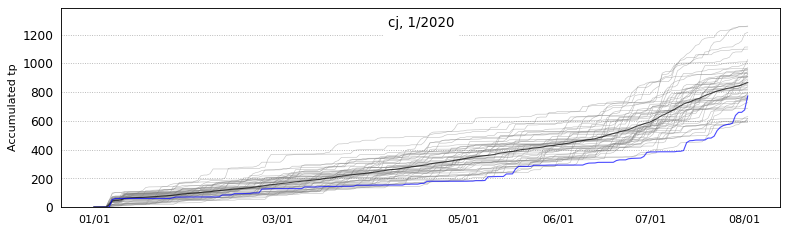

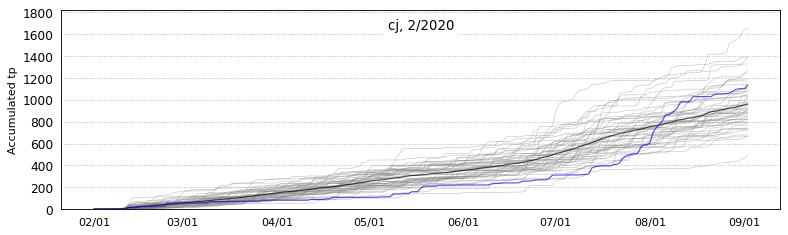

In [17]:
for years in range(start_year,end_year+1):
    
    for months in range(start_month,end_month+1):
        
        # Import Data
        path = './assessment/' + str(originating_centre.lower())+  '/' + str(catch_name)+ '_' + str(years)+'_'+str(months)+'_' + str(originating_centre) + '_' + str(variable) + '_daily.csv'
        df = pd.read_csv(path)
        df.drop(['leadtime'], axis=1, inplace=True)        
        df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True, format='%m/%d/%Y', errors='ignore')

        # Define the upper limit, lower limit, interval of Y axis and colors
        y_LL = 0
        y_UL = int(np.cumsum(df.iloc[:, 1:]).max().max()*1.1)
        y_interval = 200

        # Draw Plot and Annotate
        fig, ax = plt.subplots(1,1,figsize=(11.6, 3.3), dpi= 80)    

        columns = df.columns[1:]
        
        ensemble_members = columns[:-2].size
                
        mycolors = ['tab:grey']*ensemble_members
                    
        for i, column in enumerate(columns[:-2]):  # plot the forecast ensemble members  
            plt.plot(df.time.values, np.cumsum(df[column].values), lw=0.5, color=mycolors[i], alpha=0.5)
        
        plt.plot(df.time.values, np.cumsum(df['mean'].values), lw=1.0, color='black', alpha=0.7)
        plt.plot(df.time.values, np.cumsum(df['obs'].values), lw=1.0, color='b', alpha=0.7)

        # Decorations    
        plt.tick_params(axis="both", which="both", bottom=False, top=False,    
                        labelbottom=True, left=False, right=False, labelleft=True)        
        # Add grid lines
        plt.grid(True, axis='y', linestyle=':') 

        dateFmt = mdates.DateFormatter('%m/%d')
        ax.xaxis.set_major_formatter(dateFmt)

        plt.title(catch_name + ', ' + str(months) + '/' + str(years), x=0.5, y=0.87, fontsize=12, backgroundcolor='white')
        plt.yticks(range(y_LL, y_UL, y_interval), [str(y) for y in range(y_LL, y_UL, y_interval)], fontsize=11)    
        plt.ylabel('Accumulated ' + str(variable))
        plt.ylim(y_LL, y_UL)    
        plt.show()

#### Now, you have created seasonal forecasts time-series data successfully.